# Notes

## Introduction

### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### What Can BERT Do For Me?

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 

### Why Fine-Tuning Rather Than Building My Own Model ?

In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

#### Easy Training

First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

#### Less Data

In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

#### Good Results

Second, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.

#### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

**Note**: as of July 2019, the pytorch library called "pytorch-pretrained-bert pytorch-nlp" has been updated and renamed as "pytorch-transformers." Though the old name still works, there is a short summary [here](https://github.com/huggingface/pytorch-transformers#Migrating-from-pytorch-pretrained-bert-to-pytorch-transformers) about migrating to the new library. (This mostly involves a few name changes.)

In [5]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 6.4MB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
     |████████████████████████████████| 645kB 50.1MB/s 


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Load Dataset


We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the BERT tokenizer to break the text down into tokens and chunks that the model will recognize.

In [1]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving in_domain_train.tsv to in_domain_train.tsv


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [9]:
df.shape

(8551, 4)

In [10]:
df.sample(10)

,sentence_source,label,label_notes,sentence
2504,l-93,1,NaN,Amanda burned the stove black.
5397,b_73,1,NaN,I saw more of the man than you did.
334,bc01,0,*,Marianne not left.
7676,sks13,1,NaN,Bill cooked the rice.
1991,r-67,1,NaN,That anybody ever left at all is not certain.
1774,r-67,1,NaN,The raise which Scrooge generously gave Tom's ...
5643,c_13,0,*,The in loved peanut butter cookies.
2299,l-93,1,NaN,He turned from a prince into a frog.
6422,d_98,0,*,Any lion is generally majestic.
6147,c_13,0,*,Was sunk by the boat.


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 933701.42B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 64

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.



### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:15<00:00, 25875323.31B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [25]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
#t# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4940682981024145


Epoch:  25%|██▌       | 1/4 [03:21<10:03, 201.19s/it]

Validation Accuracy: 0.814429012345679
Train loss: 0.25364013795288765


Epoch:  50%|█████     | 2/4 [06:43<06:42, 201.42s/it]

Validation Accuracy: 0.8267746913580247
Train loss: 0.12149265737763579


Epoch:  75%|███████▌  | 3/4 [10:04<03:21, 201.51s/it]

Validation Accuracy: 0.8263888888888888
Train loss: 0.06432457060332862


Epoch: 100%|██████████| 4/4 [13:26<00:00, 201.59s/it]

Validation Accuracy: 0.8229166666666666


## Training Evaluation

Let's take a look at our training loss over all batches:

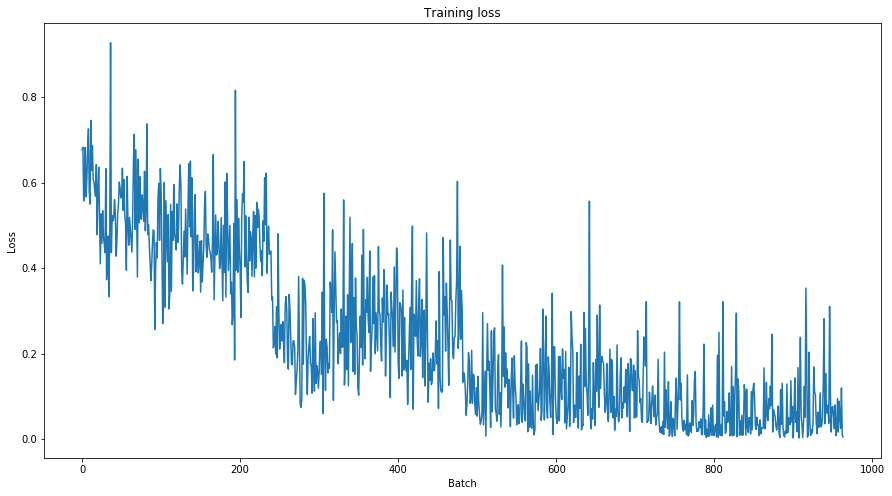

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [0]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()


Saving out_of_domain_dev.tsv to out_of_domain_dev (1).tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 64

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [0]:
matthews_set

[0.049286405809014416,
 -0.2548235957188128,
 0.5510387687779837,
 0.2809003238667948,
 0.5719694409972929,
 0.7410010097502685,
 0.37777777777777777,
 0.47519096331149147,
 0.647150228929434,
 0.7490196078431373,
 0.9229582069908973,
 0.7419408268023742,
 0.7562449037944323,
 0.7679476477883045,
 0.5204956780951701,
 0.5056936741642399,
 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5411909608645928

Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. I should also mention we didn't train on the entire training dataset, but set aside a portion of it as our validation set for legibililty of code.

If you look at the leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy), you'll see that our score (54) using the small version of BERT actually slightly outperforms the BERT authors' CoLA score (52) with the same model. If you wanted to tune the hyperparameters, use the entire train set, or use the larger BERT model instead you're likely able to push that score up higher into the mid- 60s, which looks like the state of the art as of July 2019!


## Conclusion

This post demonstrate that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.